In [23]:
import pandas as pd
from tqdm.autonotebook import tqdm
tqdm.pandas()

import ast
import os
import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist

from sklearn.preprocessing import MultiLabelBinarizer
from skimage import io
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.ion()   # interactive mode

## Initial Data

In [2]:
rows = []
with open("data/styles.csv", 'r') as f:
    keys = next(f).split(',')
    for line in f:
        rows.append(dict(zip(keys, line.split(',', 10))))

In [3]:
df = pd.DataFrame(rows)
df = df.rename(columns={"productDisplayName\n": "title"})
df.title = df.title.apply(lambda x: x.strip())

In [4]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,title
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


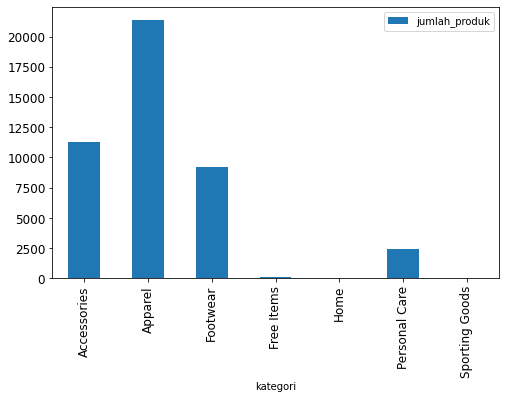

In [6]:
df.rename(columns={"masterCategory": "kategori", "id": "jumlah_produk"})[["kategori", "jumlah_produk"]].groupby("kategori").count().plot.bar(figsize=(8,5), fontsize=12)

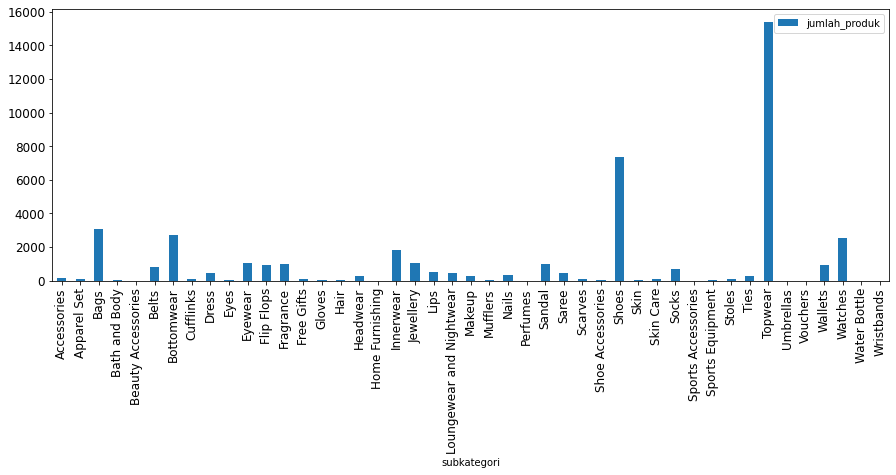

In [8]:
df.rename(columns={"subCategory": "subkategori", "id": "jumlah_produk"})[["subkategori", "jumlah_produk"]].groupby("subkategori").count().plot.bar(figsize=(15,5), fontsize=12)

## Final Data

In [9]:
df = pd.read_csv("data/styles_tags_pred.csv")

In [10]:
df.head()

,id,masterCategory,subCategory,articleType,baseColour,title,tokenized,file_name,tags,tags_pred
0,1163,Apparel,Topwear,Tshirts,Blue,Nike Sahara Team India Fanwear Round Neck Jersey,"['<start>', 'nike', 'sahara', 'team', 'india',...",1163.jpg,"['nike', 'team', 'india', 'round', 'neck', 'je...","[2.3143535e-07, 2.3702476e-09, 2.986898e-07, 3..."
1,1164,Apparel,Topwear,Tshirts,Blue,Nike Men Blue T20 Indian Cricket Jersey,"['<start>', 'nike', 'men', 'blue', 'indian', '...",1164.jpg,"['nike', 'men', 'blue', 'indian', 'cricket', '...","[2.2555818e-07, 1.8278894e-09, 7.16435e-09, 3...."
2,1165,Apparel,Topwear,Tshirts,Blue,Nike Mean Team India Cricket Jersey,"['<start>', 'nike', 'mean', 'team', 'india', '...",1165.jpg,"['nike', 'team', 'india', 'cricket', 'jersey']","[0.00035982736, 2.8710444e-06, 5.1504063e-05, ..."
3,1525,Accessories,Bags,Backpacks,Navy Blue,Puma Deck Navy Blue Backpack,"['<start>', 'puma', 'deck', 'navy', 'blue', 'b...",1525.jpg,"['puma', 'navy', 'blue', 'backpack']","[1.9060193e-05, 8.293974e-09, 9.6082715e-08, 2..."
4,1526,Accessories,Bags,Backpacks,Black,Puma Big Cat Backpack Black,"['<start>', 'puma', 'big', 'cat', 'backpack', ...",1526.jpg,"['puma', 'big', 'cat', 'backpack', 'black']","[0.0015358106, 1.2226741e-07, 7.6661183e-07, 9..."


In [18]:
removed_master_category = [
    "Home",
    "Sporting Goods",
    "Free Items"
]

df = df[~df.masterCategory.isin(removed_master_category)]

len(df)

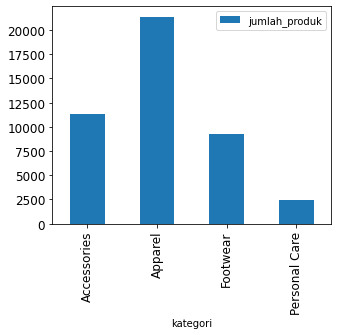

In [19]:
df.rename(columns={"masterCategory": "kategori", "id": "jumlah_produk"})[["kategori", "jumlah_produk"]].groupby("kategori").count().plot.bar(figsize=(5,4), fontsize=12)

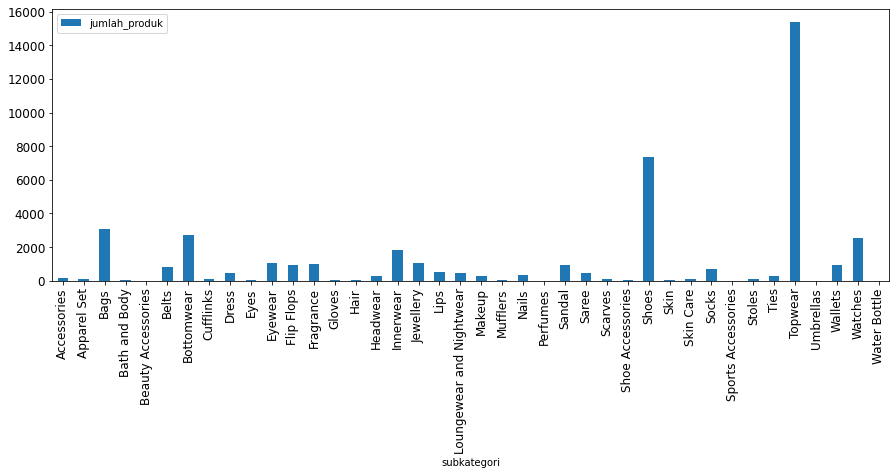

In [13]:
df.rename(columns={"subCategory": "subkategori", "id": "jumlah_produk"})[["subkategori", "jumlah_produk"]].groupby("subkategori").count().plot.bar(figsize=(15,5), fontsize=12)

In [24]:
# convert stringified-list-type columns back to list
df.tokenized = df.tokenized.apply(lambda tokens: ast.literal_eval(tokens))
df.tags_pred = df.tags_pred.apply(lambda tags: ast.literal_eval(tags))

In [25]:
labels = df.tokenized
semantic_inputs = df.tags_pred
file_names = df.file_name
categories = df.subCategory

In [26]:
X_train, X_val, labels_train, labels_val = train_test_split(list(zip(file_names, semantic_inputs, categories)), labels, test_size=0.2, random_state=105, stratify=categories)

In [28]:
import numpy as np

In [29]:
X_train = np.array(X_train)
X_val = np.array(X_val)

In [30]:
file_names_train = X_train[:, 0]
semantic_inputs_train = X_train[:, 1]
categories_train = X_train[:, 2]
file_names_val = X_val[:, 0]
semantic_inputs_val = X_val[:, 1]
categories_val = X_val[:, 2]

In [31]:
np.unique(categories_train, return_counts=True)

(array(['Accessories', 'Apparel Set', 'Bags', 'Bath and Body',
        'Beauty Accessories', 'Belts', 'Bottomwear', 'Cufflinks', 'Dress',
        'Eyes', 'Eyewear', 'Flip Flops', 'Fragrance', 'Gloves', 'Hair',
        'Headwear', 'Innerwear', 'Jewellery', 'Lips',
        'Loungewear and Nightwear', 'Makeup', 'Mufflers', 'Nails',
        'Perfumes', 'Sandal', 'Saree', 'Scarves', 'Shoe Accessories',
        'Shoes', 'Skin', 'Skin Care', 'Socks', 'Sports Accessories',
        'Stoles', 'Ties', 'Topwear', 'Umbrellas', 'Wallets', 'Watches',
        'Water Bottle'], dtype=object),
 array([  114,    85,  2442,    10,     3,   649,  2155,    86,   382,
           34,   858,   732,   806,    16,    15,   234,  1447,   864,
          422,   376,   246,    30,   263,     5,   770,   342,    94,
           19,  5874,    55,    62,   558,     2,    72,   206, 12321,
            5,   746,  2034,     6]))

In [32]:
np.unique(categories_val, return_counts=True)

(array(['Accessories', 'Apparel Set', 'Bags', 'Bath and Body',
        'Beauty Accessories', 'Belts', 'Bottomwear', 'Cufflinks', 'Dress',
        'Eyes', 'Eyewear', 'Flip Flops', 'Fragrance', 'Gloves', 'Hair',
        'Headwear', 'Innerwear', 'Jewellery', 'Lips',
        'Loungewear and Nightwear', 'Makeup', 'Mufflers', 'Nails',
        'Perfumes', 'Sandal', 'Saree', 'Scarves', 'Shoe Accessories',
        'Shoes', 'Skin', 'Skin Care', 'Socks', 'Sports Accessories',
        'Stoles', 'Ties', 'Topwear', 'Umbrellas', 'Wallets', 'Watches',
        'Water Bottle'], dtype=object),
 array([  29,   21,  610,    2,    1,  162,  538,   22,   96,    9,  215,
         183,  201,    4,    4,   59,  361,  216,  105,   94,   61,    8,
          66,    1,  192,   85,   24,    5, 1469,   14,   15,  140,    1,
          18,   52, 3080,    1,  187,  508,    1]))